In [18]:
from AtmoBuilder import AtmoBuilder
import numpy as np
import matplotlib.pyplot as plt

from astroML.plotting.mcmc import convert_to_stdev
from astroML.decorators import pickle_results

% matplotlib inline

In [19]:
ab = AtmoBuilder()

Found 16 MODTRAN files:
Pachon_MODTRAN.10.7sc
Pachon_MODTRAN.11.7sc
Pachon_MODTRAN.12.7sc
Pachon_MODTRAN.13.7sc
Pachon_MODTRAN.14.7sc
Pachon_MODTRAN.15.7sc
Pachon_MODTRAN.16.7sc
Pachon_MODTRAN.17.7sc
Pachon_MODTRAN.18.7sc
Pachon_MODTRAN.19.7sc
Pachon_MODTRAN.20.7sc
Pachon_MODTRAN.21.7sc
Pachon_MODTRAN.22.7sc
Pachon_MODTRAN.23.7sc
Pachon_MODTRAN.24.7sc
Pachon_MODTRAN.25.7sc
MODTRAN files have been read.

Read filter data from LSST software stack.
Filters: ['u', 'g', 'r', 'i', 'z', 'y4']
Read hardware data from LSST software stack.


In [20]:
ab.readAll()

# Read 988 MS stars from /Users/joachim/lsst/DarwinX86/sims_sed_library/2014.10.06/starSED/kurucz/
# Read 849 white dwarfs from /Users/joachim/lsst/DarwinX86/sims_sed_library/2014.10.06/starSED/wDs/
# Read 74 mlt stars from /Users/joachim/lsst/DarwinX86/sims_sed_library/2014.10.06/starSED/mlt/
# Generated 2520 galaxies at redshifts between 0.000000 and 3.000000
# Generated 76 quasars at redshifts between 0.000000 and 7.500000
# Generated 39 sn's at redshifts between 0.000000 and 1.200000 on days ['0', '20', '40']


In [21]:
atmo = ab.buildAtmo([1.0,1.0,1.0,2.5,0.5,1.7],1.4)

Computing nonlinear regression for Rayleigh and Aerosol.
Observed atmosphere parameters: [1.0, 1.0, 1.0, 2.5, 0.5, 1.7]
Observed atmosphere airmass:    1.4
Standard atmosphere parameters: [1.0, 1.0, 1.0, 1.0, 1.0, 1.7]
Standard atmosphere airmass:    1.2
Observed atmosphere parameter for Rayleigh: 2.5
Observed atmosphere parameter for Aerosol: 0.5

Fitting for Rayleigh between 0.20 and 5.00 in 100 bins.
Fitting for Aerosol between 0.20 and 5.00 in 100 bins.

Non-zero deltaGrey detected.
Fitting for deltaGrey between -50.00 and 50.00 mmags in 100 bins.

Regressing 1000000 parameter combinations per filter...

Calculating best fit parameters for u filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010250517_Rayleigh_Aerosol_XSTD12_DG400_E5_mss_u_100b.pkl'
Completed u filter.
Saved LogL at best fit deltaGrey for u filter.
Calculating best fit parameters for g filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010250517_Rayleigh_Aerosol_XSTD1

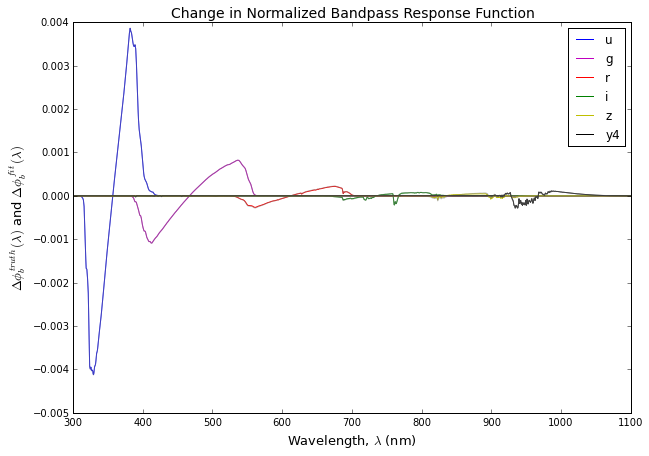

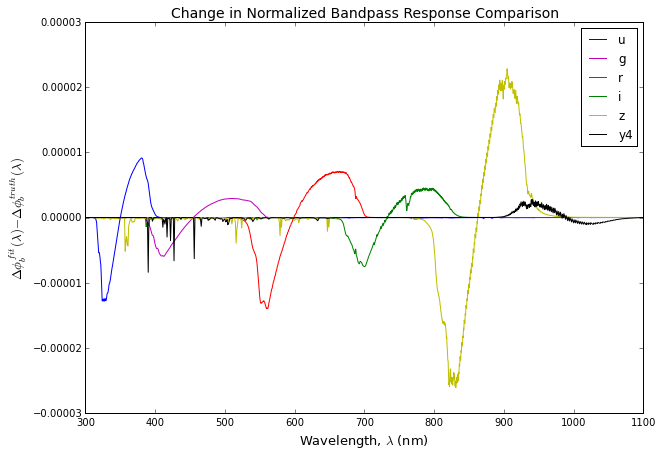

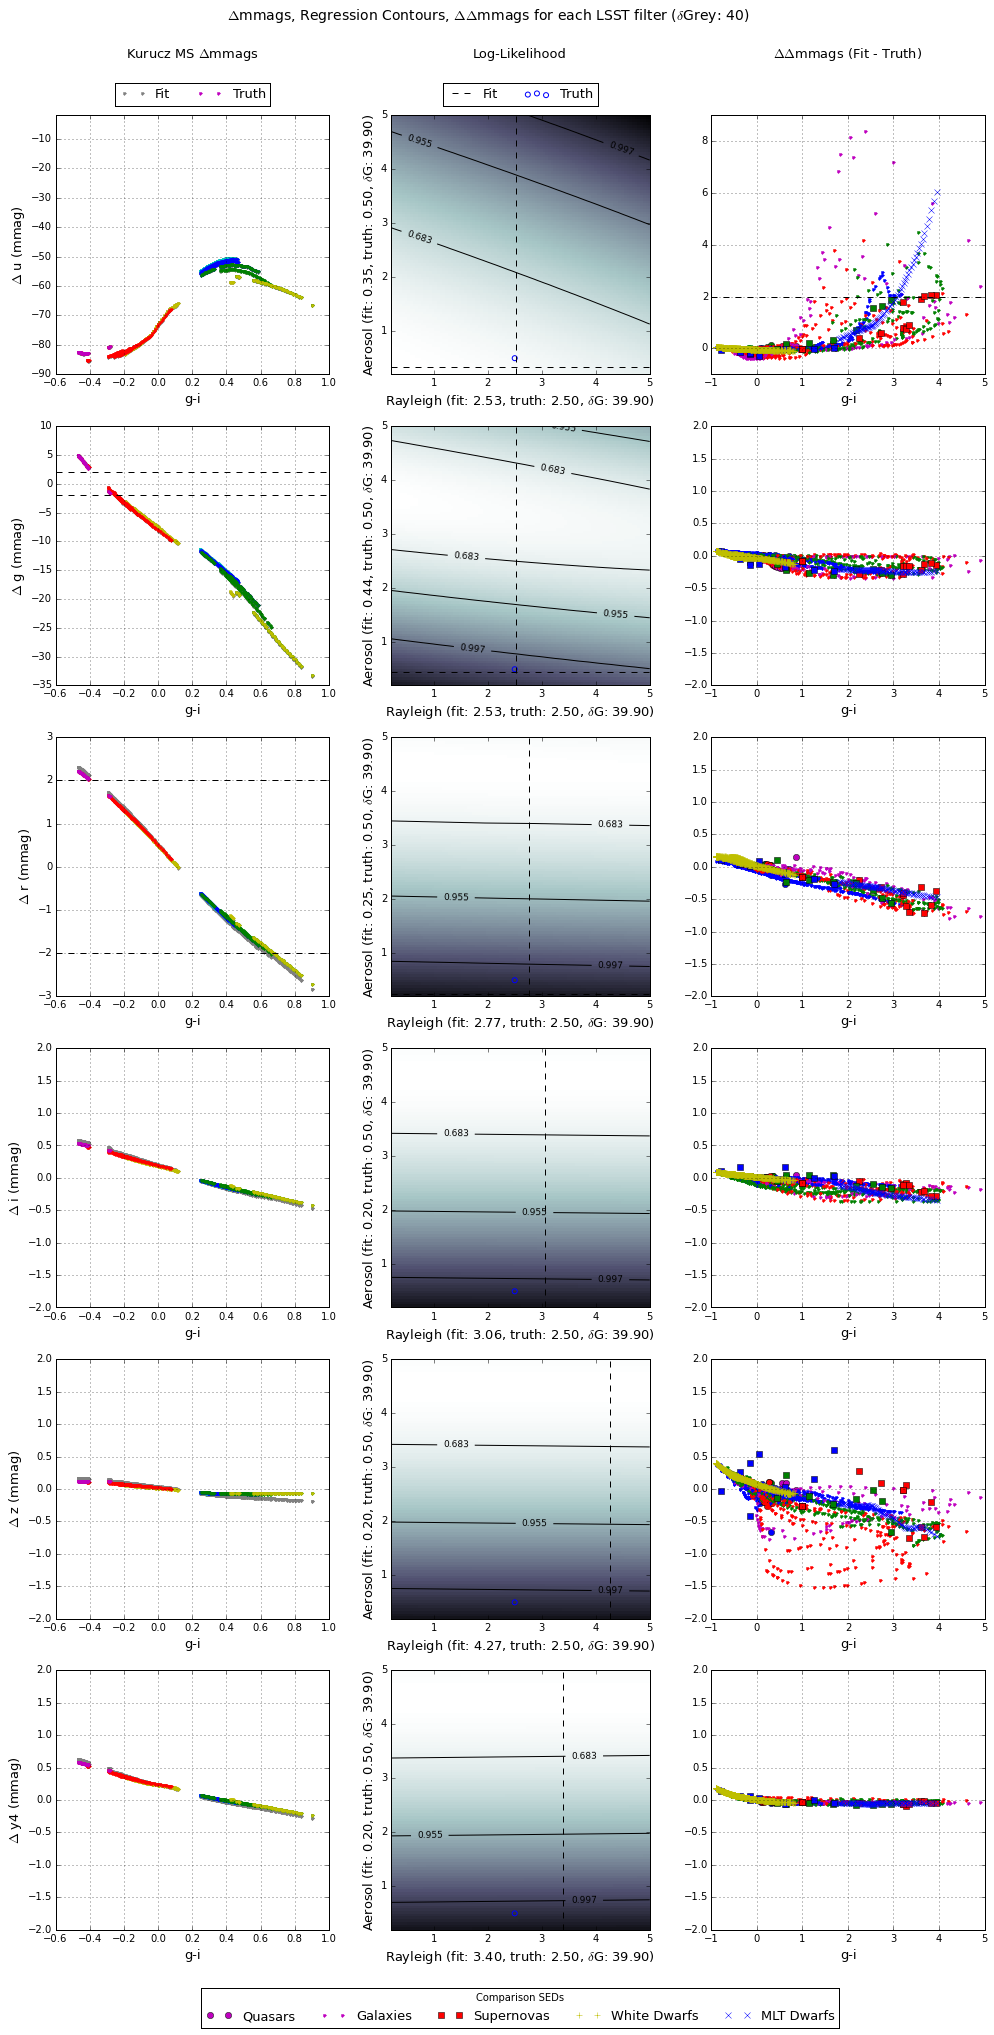

In [22]:
%time a,b,c,d = ab.computeAtmoFit('Rayleigh','Aerosol',atmo, deltaGrey=40, bins=100)

In [23]:
LABELSIZE = 10

def _logL(fig, ax, logL, plotType, comp1, comp1_obs, comp1_best, comp2, comp2_obs, comp2_best, deltaGrey, dgbest, bins,
        normalize=True, includeColorBar=False, text=None):
        """Plots desired logL plot type given figure and axis object along with appropriate data."""
        comp1_range, pNum1 = ab._componentCheck(comp1,bins)
        comp2_range, pNum2 = ab._componentCheck(comp2,bins)
        dgrange, dgnum = ab._componentCheck('deltaGrey', bins)

        """
        if deltaGrey != 0.0:
            logL = logL[:][:][np.where(dgrange == dgbest)[0][0]]
        else:
            logL = logL[:][:][0]
        """

        if normalize: 
            logL = logL / np.median(-logL)
        else:
            logL = logL

        if plotType == 'contour':
            contour = ax.contour(comp1_range, comp2_range, convert_to_stdev(logL.T), levels=(0.683, 0.955, 0.997), colors='k')
            ax.scatter(comp1_obs, comp2_obs, marker='o', s=25, facecolors='none', edgecolors='b', label='Truth')
            ax.clabel(contour, fontsize=9, inline=1)

        elif plotType == 'imshow':
            im = ax.imshow(logL.T, interpolation='nearest', cmap=plt.cm.bone, extent=(0.0,5.0,0.0,5.0), origin='lower')
            ax.scatter(comp1_obs, comp2_obs, marker='o', s=25, facecolors='none', edgecolors='b', label='Truth')
            if includeColorBar:
                fig.colorbar(im, ax=ax, format='%.0e')

        elif plotType == 'both':
            contour = ax.contour(comp1_range, comp2_range, convert_to_stdev(logL.T), levels=(0.683, 0.955, 0.997), colors='k')
            ax.scatter(comp1_obs, comp2_obs, marker='o', s=25, facecolors='none', edgecolors='b', label='Truth')
            ax.clabel(contour, fontsize=9, inline=1)
            im = ax.imshow(logL.T, interpolation='nearest', cmap=plt.cm.bone, extent=(0.0,5.0,0.0,5.0), origin='lower')
            if includeColorBar:
                fig.colorbar(im, ax=ax, format='%.0e')

        # Plot dashed lines at best fit parameters
        ax.axvline(comp1_best, color='black', linestyle='--', label='Fit')
        ax.axhline(comp2_best, color='black', linestyle='--')

        # Set y-axis, x-axis limits
        ax.set_xlim(min(comp1_range), max(comp1_range))
        ax.set_ylim(min(comp2_range), max(comp2_range))

        # Label axes
        if deltaGrey != 0.0:
            str1 = r'%s (fit: %.2f, truth: %.2f, $\delta$G: %.2f)' % (comp1, comp1_best, comp1_obs, dgbest)
            str2 = r'%s (fit: %.2f, truth: %.2f, $\delta$G: %.2f)' % (comp2, comp2_best, comp2_obs, dgbest)
        else:
            str1 = r'%s (fit: %.2f, truth: %.2f)' % (comp1, comp1_best, comp1_obs)
            str2 = r'%s (fit: %.2f, truth: %.2f)' % (comp2, comp2_best, comp2_obs)
        ax.set_xlabel(str1, fontsize=LABELSIZE)
        ax.set_ylabel(str2, fontsize=LABELSIZE)
        
        if text != None:
            ax.text(5.2,4.5,text)

        return

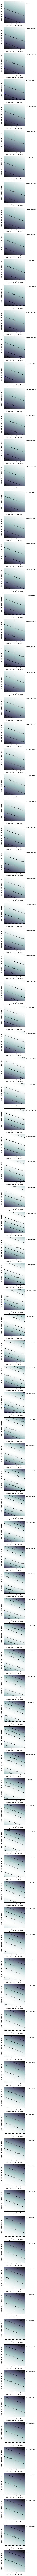

In [25]:
fig, ax = plt.subplots(100,1)
fig.set_size_inches(1*4,100*4)

logLu = d['u']
logLu.size

dgrange = np.linspace(-50,50,100)

for i in range(100):
    _logL(fig, ax[i], logLu[:][:][i], 'both', 'Rayleigh', atmo.P[4], a['u'], 'Aerosol', atmo.P[5], b['u'], 0.0, c['u'], 100, text=dgrange[i]) 